# Air Quality Prediction from Low-Cost IoT devices - By Chinonso Okonkwo
Submission to - Hackade

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score


In [2]:
# Load data
train_data = pd.read_csv("/content/Train.csv")
test_data = pd.read_csv("/content/test.csv")

In [3]:
# preview the firts five rows
print("Train Data Overview:\n")
train_data.head()

Train Data Overview:



,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name,CO2
0,ID_000001,28.975,74.475,2480.0,3476.5,1572.0,1997.0,alpha,585.75
1,ID_000002,31.900,66.500,3813.0,2726.0,4145.0,3180.0,alpha,613.00
2,ID_000003,31.675,60.015,2811.0,1563.5,4250.0,2708.5,alpha,616.50
3,ID_000004,31.580,59.220,2844.0,1597.0,4310.0,2723.0,alpha,642.50
4,ID_000005,31.690,62.030,3159.5,1120.5,5519.5,1219.0,alpha,622.00


In [4]:
# preview the first five rows of test data
print("Test Data Overview:\n")
test_data.head()

Test Data Overview:



,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name
0,ID_007308,32.450,59.990,3504.0,1380.0,2642.5,1637.0,alpha
1,ID_007309,31.665,58.640,2864.0,1659.0,4456.0,3564.5,alpha
2,ID_007310,31.755,59.000,2850.5,1615.0,4391.0,2683.5,alpha
3,ID_007311,31.860,66.850,3853.5,2868.5,4170.5,3025.5,alpha
4,ID_007312,29.600,73.115,2506.5,3631.5,1481.5,2112.5,alpha


# EDA

In [5]:
# Exploratory Data Analysis
print("Train Data Info:\n")
train_data.info()

Train Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7307 entries, 0 to 7306
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            7307 non-null   object 
 1   Temperature   7307 non-null   float64
 2   Humidity      7307 non-null   float64
 3   MQ7_analog    7307 non-null   float64
 4   MQ9_analog    7307 non-null   float64
 5   MG811_analog  7307 non-null   float64
 6   MQ135_analog  7307 non-null   float64
 7   device_name   7307 non-null   object 
 8   CO2           7307 non-null   float64
dtypes: float64(7), object(2)
memory usage: 513.9+ KB


In [6]:
# Exploratory Data Analysis
print("Test Data Info:\n")
test_data.info()

Test Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1292 non-null   object 
 1   Temperature   1292 non-null   float64
 2   Humidity      1292 non-null   float64
 3   MQ7_analog    1292 non-null   float64
 4   MQ9_analog    1292 non-null   float64
 5   MG811_analog  1292 non-null   float64
 6   MQ135_analog  1292 non-null   float64
 7   device_name   1292 non-null   object 
dtypes: float64(6), object(2)
memory usage: 80.9+ KB


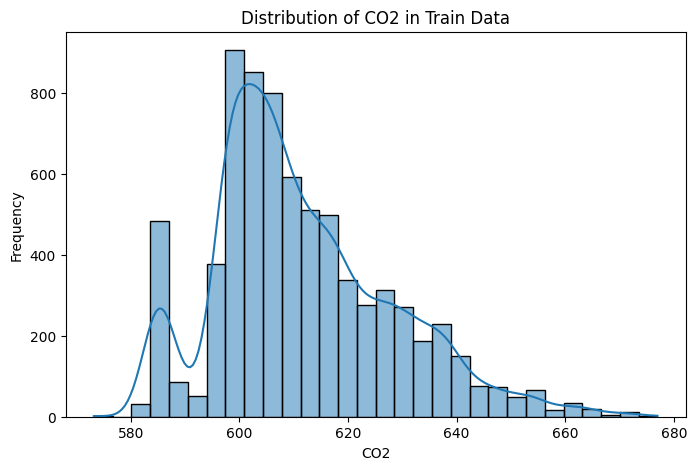

In [7]:
# Distribution of target variable
plt.figure(figsize=(8, 5))
sns.histplot(train_data['CO2'], kde=True, bins=30)
plt.title('Distribution of CO2 in Train Data')
plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.show()


Since it's a right skew, I might do a log transformation to this dependent variable

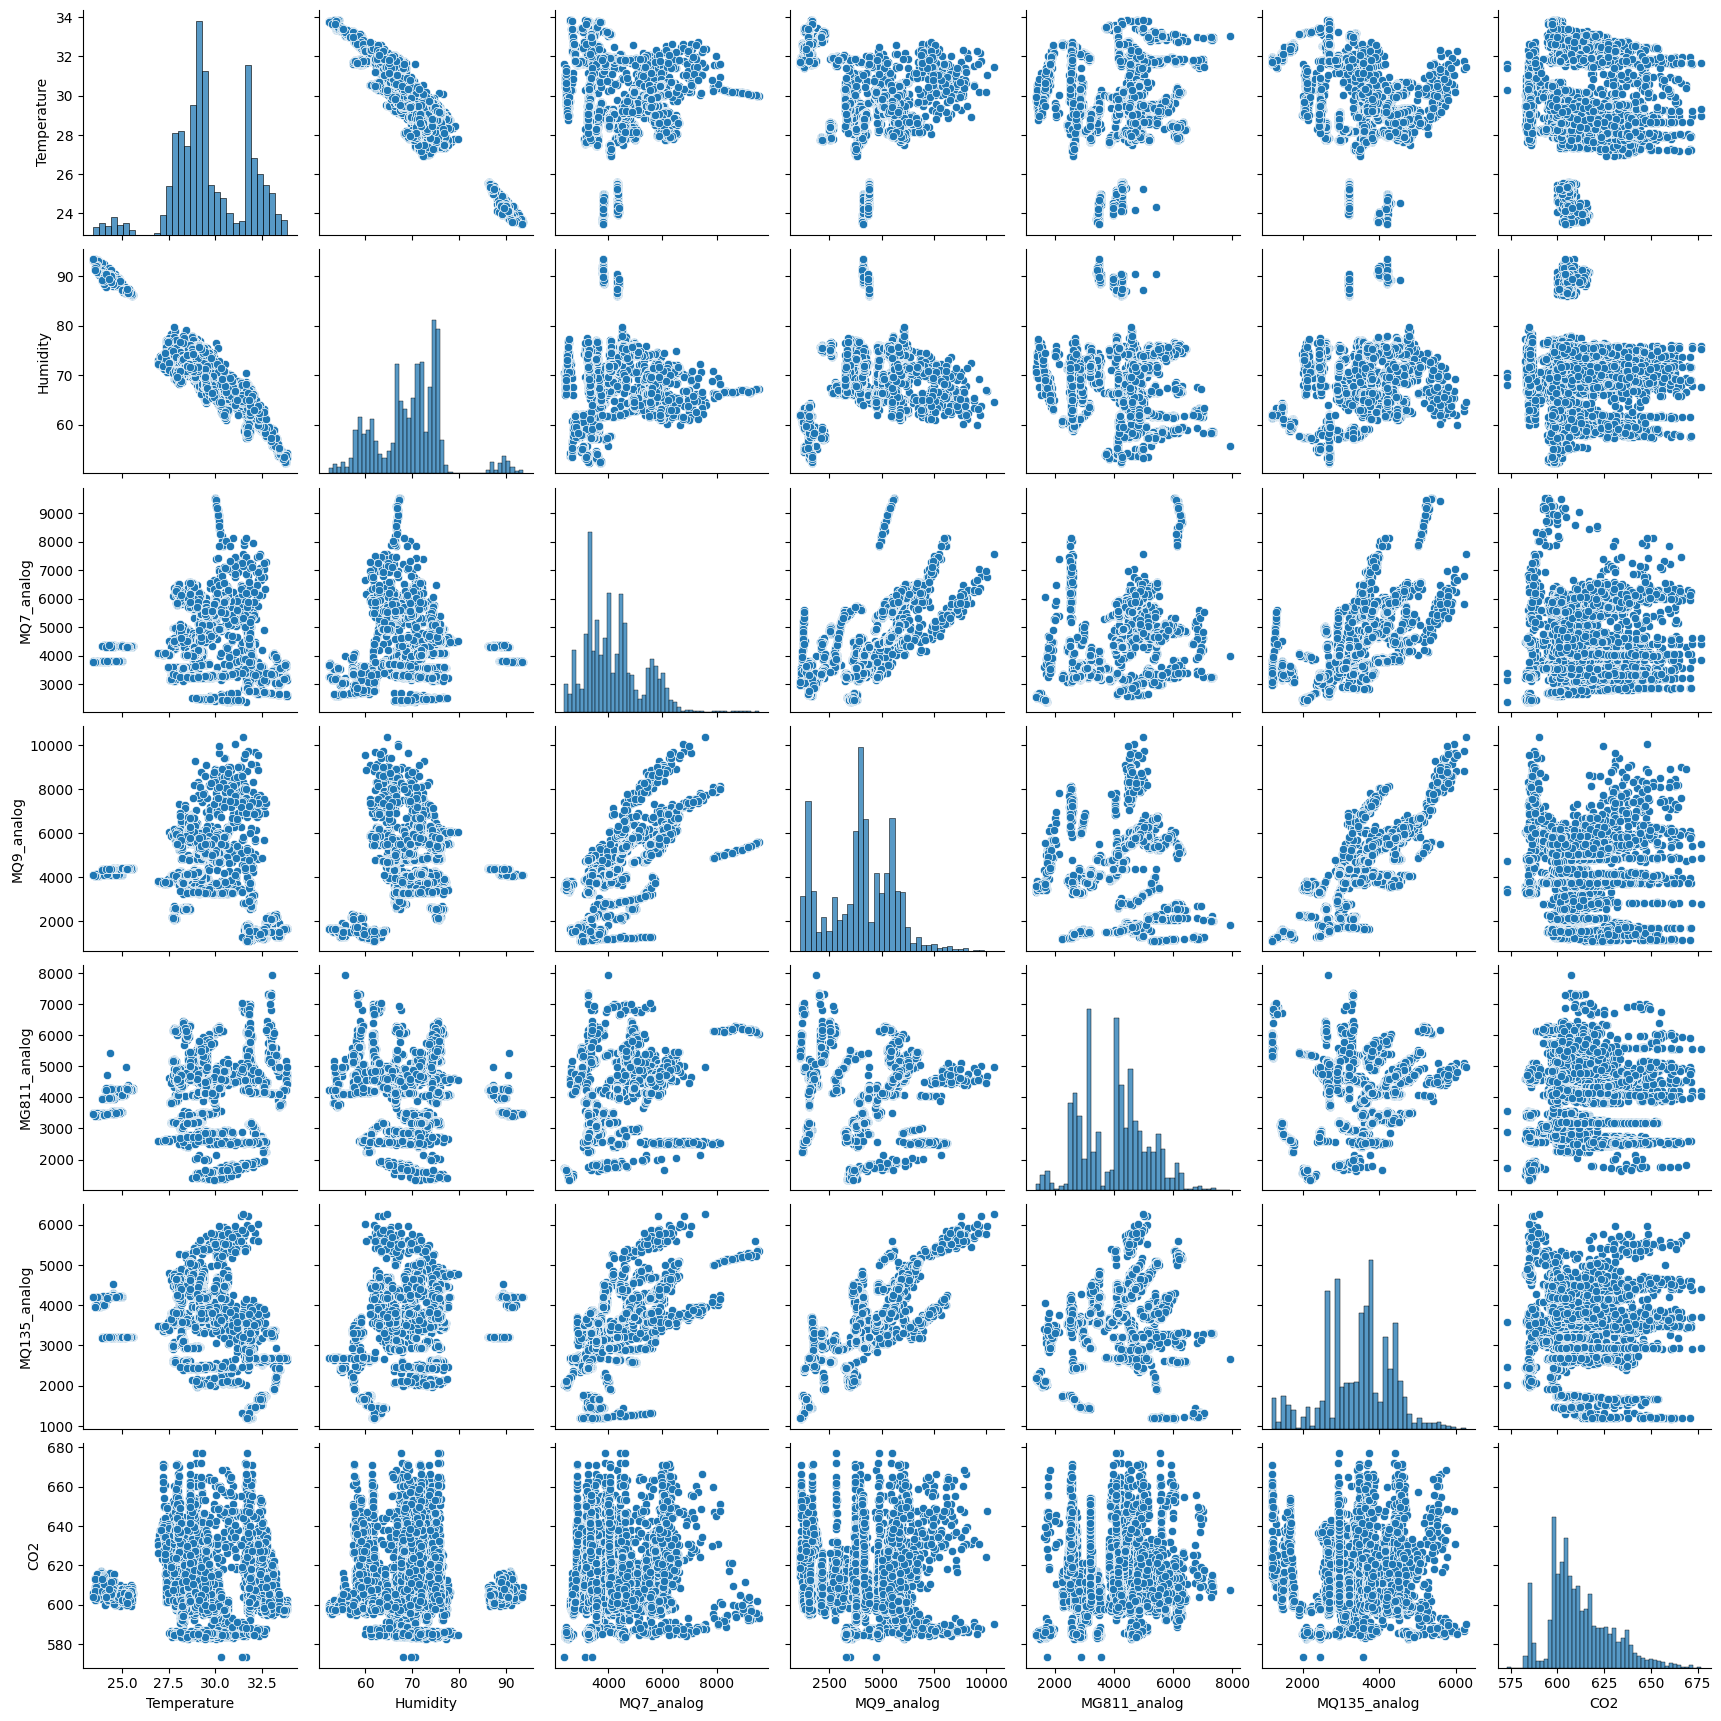

In [8]:
sns.pairplot(train_data)

# Correlation analysis

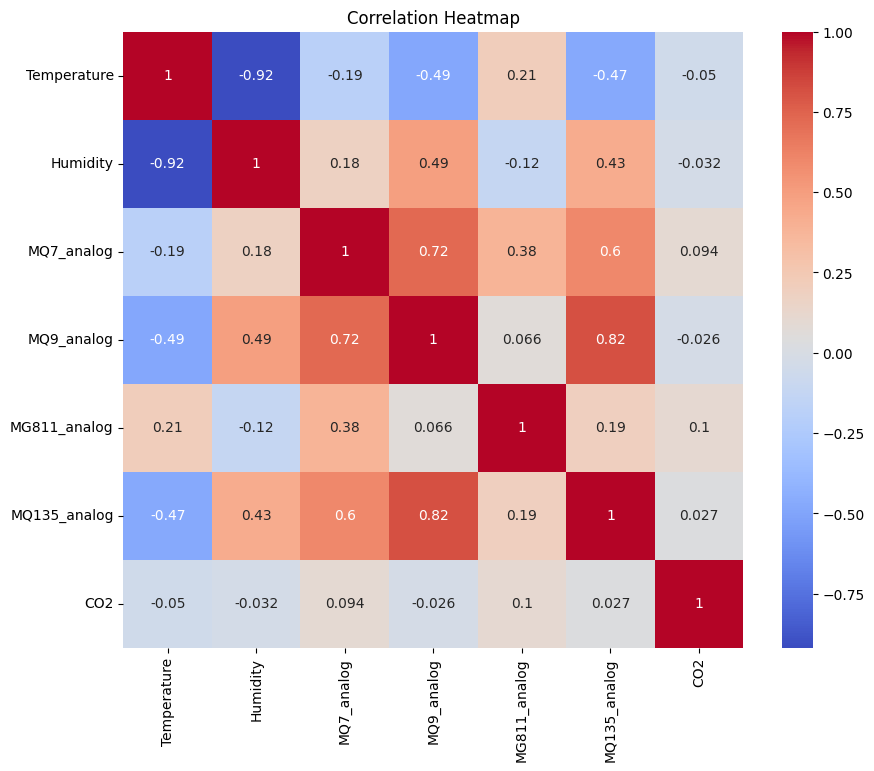

In [9]:
# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(numeric_only= True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

 # Feature Selection & Preprocessing | Feature Engineering

In [10]:
train_data.MQ7_analog.min()

2380.0

In [11]:
# Creating new features
train_data['is_alpha'] =train_data['device_name'].apply(lambda x: 1 if x == "alpha" else 0)
train_data['is_beta'] = train_data['device_name'].apply(lambda x: 1 if x == "beta" else 0)
train_data['is_charlie'] = train_data['device_name'].apply(lambda x: 1 if x == "charlie" else 0)
train_data['temperature_humidity_ratio'] = train_data['Temperature'] / train_data['Humidity']
train_data['mq7_mq9_ratio'] = train_data['MQ7_analog'] / train_data['MQ9_analog']
train_data.drop("device_name", axis=1, inplace=True)
train_data.head()


,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2,is_alpha,is_beta,is_charlie,temperature_humidity_ratio,mq7_mq9_ratio
0,ID_000001,28.975,74.475,2480.0,3476.5,1572.0,1997.0,585.75,1,0,0,0.389057,0.713361
1,ID_000002,31.900,66.500,3813.0,2726.0,4145.0,3180.0,613.00,1,0,0,0.479699,1.398753
2,ID_000003,31.675,60.015,2811.0,1563.5,4250.0,2708.5,616.50,1,0,0,0.527785,1.797889
3,ID_000004,31.580,59.220,2844.0,1597.0,4310.0,2723.0,642.50,1,0,0,0.533266,1.780839
4,ID_000005,31.690,62.030,3159.5,1120.5,5519.5,1219.0,622.00,1,0,0,0.510882,2.819723


In [12]:
# Creating new features
test_data['is_alpha'] = test_data['device_name'].apply(lambda x: 1 if x == "alpha" else 0)
test_data['is_beta'] = test_data['device_name'].apply(lambda x: 1 if x == "beta" else 0)
test_data['is_charlie'] = test_data['device_name'].apply(lambda x: 1 if x == "charlie" else 0)
test_data['temperature_humidity_ratio'] = test_data['Temperature'] / test_data['Humidity']
test_data['mq7_mq9_ratio'] = test_data['MQ7_analog'] / test_data['MQ9_analog']
test_data.drop("device_name", axis=1, inplace=True)
test_data.head()


,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,is_alpha,is_beta,is_charlie,temperature_humidity_ratio,mq7_mq9_ratio
0,ID_007308,32.450,59.990,3504.0,1380.0,2642.5,1637.0,1,0,0,0.540923,2.539130
1,ID_007309,31.665,58.640,2864.0,1659.0,4456.0,3564.5,1,0,0,0.539990,1.726341
2,ID_007310,31.755,59.000,2850.5,1615.0,4391.0,2683.5,1,0,0,0.538220,1.765015
3,ID_007311,31.860,66.850,3853.5,2868.5,4170.5,3025.5,1,0,0,0.476589,1.343385
4,ID_007312,29.600,73.115,2506.5,3631.5,1481.5,2112.5,1,0,0,0.404842,0.690211


In [13]:
train_data["CO2_lg"] = np.log(train_data["CO2"])

In [14]:
# Feature selection and preprocessing
features = ['Temperature', 'Humidity', 'MQ7_analog', 'MQ9_analog', 'MG811_analog', 'MQ135_analog',
            'is_alpha', 'is_beta', 'is_charlie', 'temperature_humidity_ratio', 'mq7_mq9_ratio']
target = 'CO2_lg'

In [15]:
X = train_data[features]
y = train_data[target]

In [16]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)

In [18]:
%%time
#Define model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

CPU times: user 6.84 s, sys: 43.2 ms, total: 6.89 s
Wall time: 6.86 s


RandomForestRegressor(random_state=42)

In [19]:
rf_model.feature_importances_

array([0.08462804, 0.14807858, 0.13193447, 0.10512172, 0.17201019,
       0.07763529, 0.00026217, 0.00035444, 0.01433928, 0.09974485,
       0.16589097])

<Axes: ylabel='None'>

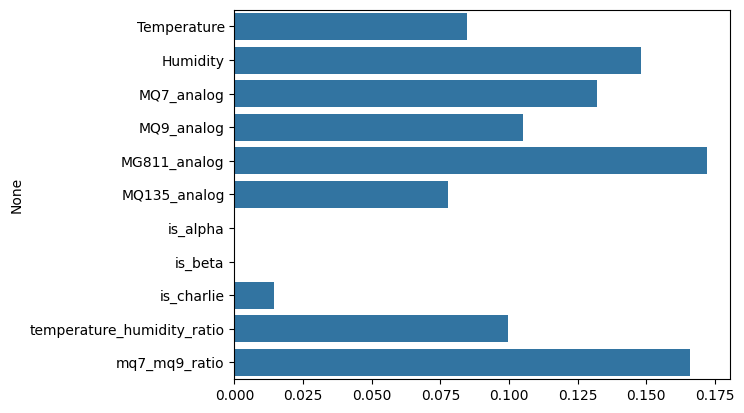

In [20]:
sns.barplot(x=rf_model.feature_importances_, y=X_train.columns)

In [21]:
%%time
val_pred = rf_model.predict(X_val)
print(mean_squared_error((y_val), np.log(val_pred)))
print(np.sqrt(mean_squared_error((y_val), np.log(val_pred))))

20.760083504764157
4.556323463579398
CPU times: user 73 ms, sys: 1.01 ms, total: 74 ms
Wall time: 86.8 ms


In [22]:
rf_model.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [23]:
%%time
# Define a custom scoring function for RMSE using log scale
def rmse_exp(y_val, val_pred):
    val_pred = np.log(val_pred)  # since y_val is in log scale, Convert pred to log scale before comparison
    return np.sqrt(mean_squared_error(y_val, val_pred))  # Compute RMSE


# Perform cross-validation
scores = cross_val_score(
    rf_model, X_train, y_train,
    scoring=make_scorer(rmse_exp, greater_is_better=False),
    cv=5  # 5-fold cross-validation
)

print(f"Cross-validated RMSE scores: {-scores}")  # Convert to positive for readability
print(f"Mean RMSE: {-scores.mean()}")


Cross-validated RMSE scores: [4.55721421 4.55694237 4.5569325  4.55749025 4.55786964]
Mean RMSE: 4.55728979260874
CPU times: user 29.4 s, sys: 86 ms, total: 29.5 s
Wall time: 31.6 s


In [24]:
test_data.head()

,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,is_alpha,is_beta,is_charlie,temperature_humidity_ratio,mq7_mq9_ratio
0,ID_007308,32.450,59.990,3504.0,1380.0,2642.5,1637.0,1,0,0,0.540923,2.539130
1,ID_007309,31.665,58.640,2864.0,1659.0,4456.0,3564.5,1,0,0,0.539990,1.726341
2,ID_007310,31.755,59.000,2850.5,1615.0,4391.0,2683.5,1,0,0,0.538220,1.765015
3,ID_007311,31.860,66.850,3853.5,2868.5,4170.5,3025.5,1,0,0,0.476589,1.343385
4,ID_007312,29.600,73.115,2506.5,3631.5,1481.5,2112.5,1,0,0,0.404842,0.690211


In [25]:
X_test = test_data.drop("ID", axis =1)
X_test.head()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,is_alpha,is_beta,is_charlie,temperature_humidity_ratio,mq7_mq9_ratio
0,32.450,59.990,3504.0,1380.0,2642.5,1637.0,1,0,0,0.540923,2.539130
1,31.665,58.640,2864.0,1659.0,4456.0,3564.5,1,0,0,0.539990,1.726341
2,31.755,59.000,2850.5,1615.0,4391.0,2683.5,1,0,0,0.538220,1.765015
3,31.860,66.850,3853.5,2868.5,4170.5,3025.5,1,0,0,0.476589,1.343385
4,29.600,73.115,2506.5,3631.5,1481.5,2112.5,1,0,0,0.404842,0.690211


In [26]:
y_test = rf_model.predict(X_test)
y_test = np.exp(y_test)
y_test

# Reshape the predicted values to be a 1-dimensional array
y_test  = y_test.reshape(-1)

# Create a DataFrame with ID and predicted price columns
submission_df = pd.DataFrame({'ID': test_data['ID'], 'CO2': y_test })
submission_df

,ID,CO2
0,ID_007308,632.303350
1,ID_007309,648.478184
2,ID_007310,626.920188
3,ID_007311,629.044303
4,ID_007312,584.730736
...,...,...
1287,ID_008595,629.483735
1288,ID_008596,606.133468
1289,ID_008597,617.267507
1290,ID_008598,631.437783


In [27]:
submission_df.to_csv("submission.csv", index=False)